# The Universality of IOWA —— Parking patterns and Resource Allocation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv('/Users/sijieliu/Desktop/Data Practice/CardTransaction.csv')


In [33]:
df['EntranceTime'] = pd.to_datetime(df['EntranceTime'], errors='coerce')
df['ExitTime'] = pd.to_datetime(df['ExitTime'], errors='coerce')
df['EntranceTime'] = df['EntranceTime'].dt.floor('s')
df['ExitTime'] = df['ExitTime'].dt.floor('s')

## Data Preprocess



In [37]:
# Fill EntranceTime with ExitTime 12:00 AM on the same day
df['EntranceTime'] = df.apply(
    lambda row: pd.Timestamp.combine(row['ExitTime'].date(), pd.to_datetime('00:00:00').time())
    if pd.isnull(row['EntranceTime']) and not pd.isnull(row['ExitTime'])
    else row['EntranceTime'],
    axis=1
)

# Fill ExitTime with EntranceTime of the current day at 23:59:59
df['ExitTime'] = df.apply(
    lambda row: pd.Timestamp.combine(row['EntranceTime'].date(), pd.to_datetime('23:59:59').time())
    if pd.isnull(row['ExitTime']) and not pd.isnull(row['EntranceTime'])
    else row['ExitTime'],
    axis=1
)


### Vehicle entry trends

In [102]:
#1. Discretize the time by dividing the 24 hours of a day into hourly intervals
def get_time_slot(hour):
    hour =int(hour)
    return f"{hour:02d}:00 - {hour+1:02d}:00"

df['Hour'] = df['EntranceTime'].dt.hour
df['EntranceTimeSlot'] = df['Hour'].apply(get_time_slot)
df['Date'] = df['EntranceTime'].dt.date

In [105]:
#2.Count every record of using the card during the set time period
usage_by_day_entranceslot = df.groupby(['Date', 'EntranceTimeSlot']).size().reset_index(name='Usage')

#3. Find the peak entrance time of each day
daily_peak_entranceslot = usage_by_day_entranceslot.sort_values(['Date', 'Usage'], ascending=[True, False]).drop_duplicates('Date')

#4. Count the frequency of these peak periods in the whole
peak_entrance_slot_distribution = daily_peak_entranceslot['EntranceTimeSlot'].value_counts().reset_index()
peak_entrance_slot_distribution.columns = ['EntranceTimeSlot', 'PeakDaysCount']


In [119]:
peak_entrance_slot_distribution

,EntranceTimeSlot,PeakDaysCount
0,07:00 - 08:00,673
1,06:00 - 07:00,339
2,08:00 - 09:00,140
3,00:00 - 01:00,19
4,05:00 - 06:00,2
5,22:00 - 23:00,2
6,15:00 - 16:00,1
7,12:00 - 13:00,1
8,11:00 - 12:00,1
9,03:00 - 04:00,1


In [120]:
peak_entrance_slot_avg_usage = daily_peak_entranceslot.groupby('EntranceTimeSlot')['Usage'].mean().reset_index()
peak_entrance_slot_avg_usage.columns = ['EntranceTimeSlot', 'AvgEntranceCount']


final_entrance_summary = pd.merge(peak_entrance_slot_distribution, peak_entrance_slot_avg_usage, on='EntranceTimeSlot')

print(final_entrance_summary)

   EntranceTimeSlot  PeakDaysCount  AvgEntranceCount
0     07:00 - 08:00            673        376.423477
1     06:00 - 07:00            339        255.032448
2     08:00 - 09:00            140        420.750000
3     00:00 - 01:00             19         33.684211
4     05:00 - 06:00              2          1.000000
5     22:00 - 23:00              2         11.000000
6     15:00 - 16:00              1          1.000000
7     12:00 - 13:00              1          2.000000
8     11:00 - 12:00              1          1.000000
9     03:00 - 04:00              1          1.000000
10    10:00 - 11:00              1          6.000000
11    16:00 - 17:00              1          1.000000


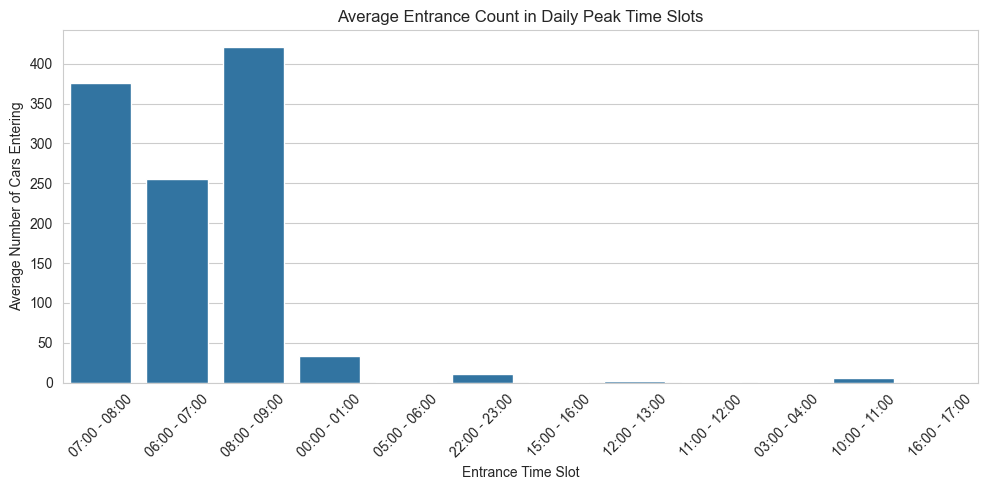

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=final_entrance_summary, x='EntranceTimeSlot', y='AvgEntranceCount')

plt.title('Average Entrance Count in Daily Peak Time Slots')
plt.xlabel('Entrance Time Slot')
plt.ylabel('Average Number of Cars Entering')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis of simultaneous parking in daily units

In [111]:
# 1.Set 1h as the time interval
time_slots = pd.date_range(
    start=df['EntranceTime'].min().floor('D'),
    end=df['ExitTime'].max().ceil('D'),
    freq='1h'
)

# 2. Find all covered TimeSlots for each record
expanded_records = []

for idx, row in df.iterrows():
    entrance = row['EntranceTime']
    exit_time = row['ExitTime']
    current_slots = time_slots[(time_slots >= entrance.floor('D')) & (time_slots < exit_time)]

    # Filter the time period actually covered by this vehicle
    actual_slots = current_slots[(current_slots >= entrance) & (current_slots < exit_time)]

    for slot_start in actual_slots:
        expanded_records.append({
            'Date': slot_start.date(),
            'TimeSlotStart': slot_start.time(),
            'CardNumber': row['CardNumber']
        })

# 3. convert to DataFrame
expanded_df = pd.DataFrame(expanded_records)

# 4. Count the number of vehicles in each time period every day (de-duplicated CardNumber)
usage_summary = expanded_df.groupby(['Date', 'TimeSlotStart'])['CardNumber'].nunique().reset_index(name='OccupiedCars')

daily_peak_slot = usage_summary.sort_values(['Date', 'OccupiedCars'], ascending=[True, False]).drop_duplicates('Date')
#5.
# Count which time periods are most often peak times
peak_slot_distribution = daily_peak_slot['TimeSlotStart'].value_counts().reset_index()
peak_slot_distribution.columns = ['TimeSlotStart', 'PeakDaysCount']

# Sorting time period
peak_slot_distribution = peak_slot_distribution.sort_values('TimeSlotStart')


In [123]:
peak_slot_avg_occupancy = daily_peak_slot.groupby('TimeSlotStart')['OccupiedCars'].mean().reset_index()
peak_slot_avg_occupancy.columns = ['TimeSlotStart', 'AvgOccupiedCars']


final_summary = pd.merge(peak_slot_distribution, peak_slot_avg_occupancy, on='TimeSlotStart')


In [158]:
import plotly.express as px

fig = px.bar(
    peak_slot_distribution,
    x='TimeSlotStart',
    y='PeakDaysCount',
    title='Most Frequent Peak Time Slots',
    labels={
        'TimeSlotStart': 'Time Slot Start (1-Hour Interval)',
        'PeakDaysCount': 'Number of Days as Peak'
    },
    text='PeakDaysCount'
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


#### 11 o'clock is usually the peak time for parking.

In [154]:
import plotly.express as px

fig = px.bar(
    final_summary,
    x='TimeSlotStart',
    y='AvgOccupiedCars',
    title='Average Occupied Cars in Peak Time Slots',
    labels={'TimeSlotStart': 'Time Slot Start', 'AvgOccupiedCars': 'Average Occupied Cars'},
    text='AvgOccupiedCars'
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


In [126]:
max_occupied = usage_summary['OccupiedCars'].max()
print(f"The maximum number of vehicles occupying the vehicle at the same time in a day is：{max_occupied}")

The maximum number of vehicles occupying the vehicle at the same time in a day is：2275


#### Based on the daily parking situation, 11:00 a.m. to 3:00 p.m. is the time when the most vehicles appear at the same time. Also，The maximum number of vehicles parked at the same time is 2,275. If the number of parking spaces is 16,000, we can consider issuing some new cards in the future.



## Analysis of simultaneous parking in weekly units



In [130]:
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
df['Weekday'] = df['Date'].dt.day_name()

In [133]:
weekly_occupancy = (
     df.groupby(['Week', 'Weekday'])['CardNumber']
    .nunique()
    .reset_index(name='OccupiedCars')
)
weekly_peak_day = (
    weekly_occupancy
    .sort_values(['Week', 'OccupiedCars'], ascending=[True, False])
    .drop_duplicates('Week')
)

peak_day_distribution = (
    weekly_peak_day['Weekday']
    .value_counts()
    .reset_index()
)
peak_day_distribution.columns = ['Weekday', 'PeakDayCount']

In [134]:
import plotly.express as px


fig = px.bar(
    peak_day_distribution,
    x='Weekday',
    y='PeakDayCount',
    title='Most Frequent Peak Day in Weekly Parking Usage',
    labels={'Weekday': 'Day of Week', 'PeakDayCount': 'Times as Weekly Peak'},
    category_orders={'Weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']},
    text='PeakDayCount'
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Weekday', yaxis_title='Number of Weeks as Peak Day')
fig.show()

#### From a weekly perspective, vehicle occupancy levels are highest on Tuesdays and Wednesdays, indicating these weekdays as the most frequent peak usage days


## Analysis of simultaneous parking in years


In [152]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

monthly_stats = (
    df.groupby(['Year', 'Month'])['CardNumber']
    .nunique()
    .reset_index(name='OccupiedCars')
)

In [153]:
# Month name mapping
import plotly.graph_objects as go

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_stats['MonthName'] = monthly_stats['Month'].apply(lambda x: month_names[x-1])


fig = go.Figure()

years = sorted(monthly_stats['Year'].unique())


for i, year in enumerate(years):
    df_year = monthly_stats[monthly_stats['Year'] == year]
    fig.add_trace(
        go.Bar(
            x=df_year['MonthName'],
            y=df_year['OccupiedCars'],
            name=str(year),
            visible=(i == 0)  # 只有第一个年份可见
        )
    )


buttons = []
for i, year in enumerate(years):
    visibility = [False] * len(years)
    visibility[i] = True
    buttons.append(dict(
        label=str(year),
        method='update',
        args=[{'visible': visibility},
              {'title': f'Parking Usage by Month — {year}'}]
    ))


fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="right",
        x=0.5, xanchor="center",
        y=1.15, yanchor="top"
    )],
    title=f'Parking Usage by Month — {years[0]}',
    xaxis_title='Month',
    yaxis_title='Number of Occupied Cars',
    showlegend=False,
    template='plotly_white'
)

fig.show()

In [162]:
df

,TransactionId,CardNumber,LotNumber,NoEntry,NoExit,Overnight,EntranceTime,ExitTime,EffectiveGroupNumber,EntranceDate,Hour,TimeSlot,Date,EntranceTimeSlot,Week,Weekday,Year,Month,PeakUsage
0,27608086,43976,3,0,0,0,2024-02-07 08:00:14,2024-02-07 15:58:23,47,2024-02-07,8,08:00 - 09:00,2024-02-07,08:00 - 09:00,2024-02-05,Wednesday,2024,2,189
1,27615712,18867,11,0,0,0,2024-02-08 06:58:36,2024-02-08 08:19:16,81,2024-02-08,6,06:00 - 07:00,2024-02-08,06:00 - 07:00,2024-02-05,Thursday,2024,2,337
2,27615955,14512,21,0,1,0,2024-02-07 10:02:49,2024-02-07 23:59:59,24,2024-02-07,10,10:00 - 11:00,2024-02-07,10:00 - 11:00,2024-02-05,Wednesday,2024,2,72
3,27617648,3548,11,0,0,0,2024-02-08 07:57:37,2024-02-08 11:49:23,72,2024-02-08,7,07:00 - 08:00,2024-02-08,07:00 - 08:00,2024-02-05,Thursday,2024,2,337
4,27620719,57888,24,0,0,0,2024-02-08 07:44:00,2024-02-08 16:30:57,33,2024-02-08,7,07:00 - 08:00,2024-02-08,07:00 - 08:00,2024-02-05,Thursday,2024,2,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148599,19980652,11469,80,0,0,1,2021-08-01 18:46:37,2021-08-02 07:37:30,81,2021-08-01,18,18:00 - 19:00,2021-08-01,18:00 - 19:00,2021-07-26,Sunday,2021,8,144
2148600,19990466,47122,80,0,0,0,2021-07-14 06:57:29,2021-07-14 19:37:02,81,2021-07-14,6,06:00 - 07:00,2021-07-14,06:00 - 07:00,2021-07-12,Wednesday,2021,7,142
2148601,20445002,63732,50,0,0,1,2021-09-22 15:52:08,2021-09-23 00:34:44,80,2021-09-22,15,15:00 - 16:00,2021-09-22,15:00 - 16:00,2021-09-20,Wednesday,2021,9,138
2148602,20083047,30722,13,0,0,0,2021-08-12 06:41:56,2021-08-12 16:38:15,37,2021-08-12,6,06:00 - 07:00,2021-08-12,06:00 - 07:00,2021-08-09,Thursday,2021,8,62


In [163]:
df.to_csv('/Users/sijieliu/Desktop/Data Practice/df.csv')

#### From the monthly parking trends of each year, we can see that June and July are relatively less busy. After July, the parking time increases. This is consistent with the fact that July is the move-in date for students.

## Forecasting for the future 2025


In [155]:
time_grid = pd.date_range(
    start=df['EntranceTime'].min().floor('D'),
    end=df['ExitTime'].max().ceil('D'),
    freq='1h'
)

records = []

for time_point in time_grid:
    active = df[(df['EntranceTime'] <= time_point) & (df['ExitTime'] > time_point)]
    usage_by_lot = active.groupby('LotNumber')['CardNumber'].nunique().reset_index(name='Occupied')
    usage_by_lot['Time'] = time_point
    records.append(usage_by_lot)

occupancy_df = pd.concat(records)

occupancy_df['Year'] = occupancy_df['Time'].dt.year
occupancy_df['Month'] = occupancy_df['Time'].dt.month

monthly_peak_usage = occupancy_df.groupby(['LotNumber', 'Year', 'Month'])['Occupied'].max().reset_index()
monthly_peak_usage = monthly_peak_usage.rename(columns={'Occupied': 'PeakUsage'})

df = df.merge(
    monthly_peak_usage,
    on=['LotNumber', 'Year', 'Month'],
    how='left'
)

In [ ]:
grouped_df = monthly_lot_usage_df.groupby(['LotNumber', 'Year', 'Month'])['PeakUsage'].sum().reset_index()


#### After obtaining the monthly time series data for each parking lot, I plan to apply SARIMA to analyze the monthly patterns, incorporating variables such as holidays and academic calendar cycles into a regression-based modeling approach, with weekly fluctuations serving as auxiliary predictors to enhance forecasting accuracy.
#### Since the peak usage of parking lots shows a consistent trend across previous years, I expect a similar increase in peak usage to occur from August to December in 2025.